In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

plt.rcParams["figure.figsize"] = (13, 7)

# Wolt Data Science Assignment 2022
### Karl Hendrik Nurmeots

# Introduction

Hey! Thank you for taking the time to read through my assignment submission!

In this assignment I will be exploring the provided Wolt orders data and developing models to forecast the number of orders per hour for the next 24 hours based on the preceding 48 hours. As Wolt is a platform that connects thousands of restaurants and vendors with thousands of customers by involving thousands of drivers, it is a big logistical challenge that could greatly benefit from having accurate predictions for the number of orders.

I begin by analyzing the Wolt orders dataset using visualizations that produce insights into how this problem should be modeled. Then, I propose a seq2seq recurrent neural network model for solving the problem and evaluate its performance. I improve the model further by adding additional, non-time series features to the model. Finally, I explain a bit about what motivates me to work at Wolt and how my past experiences make me a great candidate for the position.

# Data Preparation

In [ ]:
#### Data Preparation
df = pd.read_csv('https://raw.githubusercontent.com/woltapp/data-science-summer-intern-2022/master/orders_autumn_2020.csv')
df.columns = ['timestamp', 'delivery_delay', 'item_count', 'user_lat', 'user_long', 'venue_lat', 'venue_long',
             'delivery_estimate', 'delivery_actual', 'cloud_coverage', 'temperature', 'wind_speed', 'precipitation']
df.timestamp = pd.to_datetime(df.timestamp)

# Timestamps are given with minute-precision, so round all timestamps down to their hour
df.timestamp = df.timestamp.apply(lambda x: datetime(x.year, x.month, x.day, x.hour, 0))

# Group by timestamp
gb = df.groupby('timestamp').agg({'timestamp': 'count'})
gb.columns = ['orders']

# There may be hours where no orders were placed, so generate all hours from Aug 1 to Sept 30 and join with data
hours = pd.Series(pd.date_range(start=datetime(2020, 8, 1), end=datetime(2020, 9, 30, 23), freq='1H'))
gb = gb.merge(hours.rename('hours'), how='right', left_index=True, right_on='hours')
gb = gb.set_index('hours')

# Replace NaN orders with 0
#### Here I am assuming that there is no reason for data to be missing besides no orders being made:
#### if this was not assumed, it might be better to replace the missing values with something like -1
#### so that the models can learn that these particular datapoints contain no useful information
gb.orders = gb.orders.fillna(0)

gb['hour'] = gb.index.hour
gb['weekday'] = gb.index.weekday

# Exploratory Data Analysis

In this section my goal is to visually analyze the data to understand its behaviour, and what aspects of the data the forecasting models should understand.

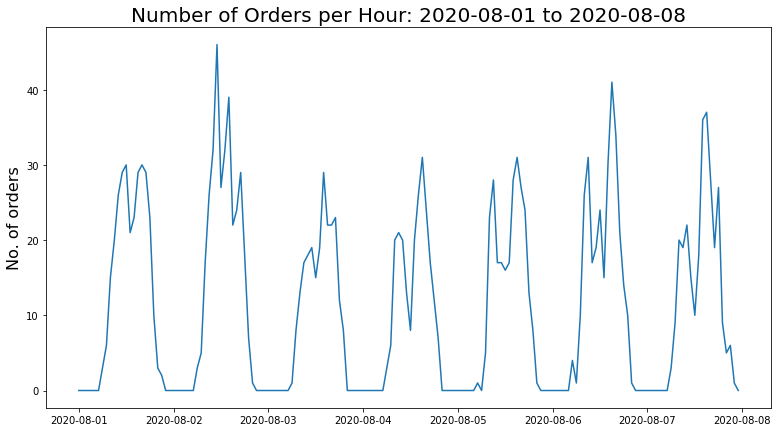

In [ ]:
# Beginning date for graph
date = datetime(2020, 8, 1)

temp = gb[(gb.index >= date) & (date + timedelta(days=7) > gb.index)]

plt.plot(temp.index, temp.orders)
plt.title(f"Number of Orders per Hour: {date.date()} to {(date + timedelta(days=7)).date()}", fontsize=20)
plt.ylabel('No. of orders', fontsize=16)
plt.show()

Looking at the first week of the dataset a clear pattern emerges: most days in this week display two distinct peaks in the number of orders, although some days also showcase a third peak. 

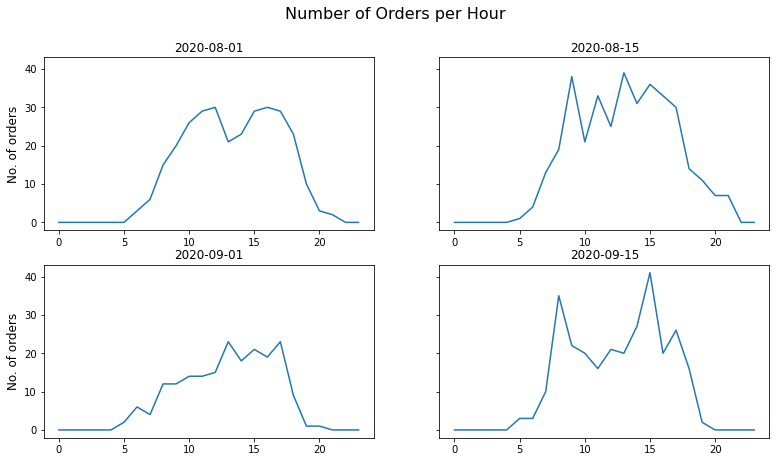

In [ ]:
dates = [datetime(2020, 8, 1), datetime(2020, 8, 15), datetime(2020, 9, 1), datetime(2020, 9, 15)]

fig, axs = plt.subplots(2, 2, sharey=True)
for i in range(len(axs.flatten())):
  ax = axs.flatten()[i]
  date = dates[i]
  temp = gb[(gb.index >= date) & (date + timedelta(days=1) > gb.index)]

  ax.plot(temp.index.hour, temp.orders)
  if i in (0, 2):
    ax.set_ylabel('No. of orders', fontsize=12)
  ax.set_title(str(date.date()))
plt.suptitle('Number of Orders per Hour', fontsize=16)
plt.show()

Looking at four days separately we see that some days do not follow the previously observed bimodality at all. The peaks in these days also occur at different times. September 1, 2020 is a particularly anomalyous day as it displays a completely different pattern from most other days in the dataset.

It is clear that this time series data is somewhat complex and we want to model it by using techniques that can obtain a good understanding of how the data behaves.

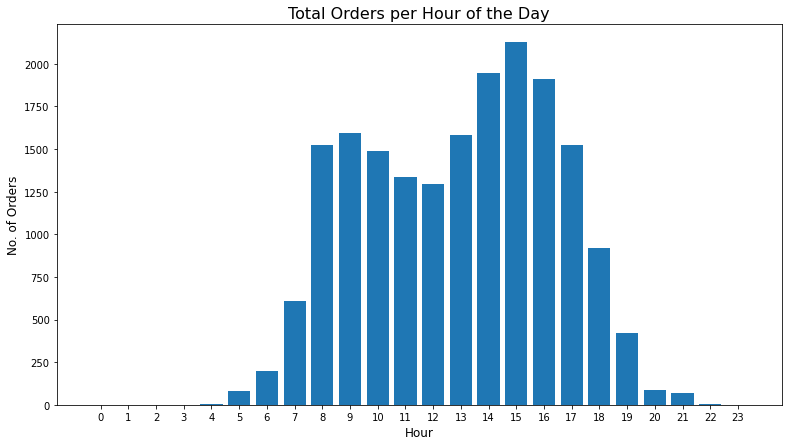

In [ ]:
temp = gb.groupby('hour').agg({'orders': 'sum'})
plt.bar(temp.index, temp.orders)
plt.xticks(np.arange(24))
plt.xlabel("Hour", fontsize=12)
plt.ylabel("No. of Orders", fontsize=12)
plt.title("Total Orders per Hour of the Day", fontsize=16)
plt.show()

Looking at the distribution of orders per hour of the day we once again see the bimodal pattern observed earlier. This shows that, on average, the first peak of orders occurs at 09:00, and the second peak tends to occur at 15:00.

With more time, I would dig deeper into how the distribution of orders differs across different weekdays, especially weekends. Taking holidays and otherwise significant days of the year into account could also yield valuable information. These insights could be useful in improving the models that follow. 

# Modeling

If I was solving this problem while working for Wolt and if I had more time, I would approach the problem by first trying out simple models and then seeing if more complicated ones can improve on the results. A great baseline model for time series forecasting is simply using the past 48 hours' data as the prediction for the next 24: if the patterns in the data have little variation, this super simple model can be a surprisingly tough baseline to beat. Other simple models to try on this problem would be linear regression and ARIMA.

However, for this assignment for the sake of saving time I will break my principle and jump directly to the cool stuff - recurrent neural networks (RNNs). RNNs are great at modeling complex patterns and behaviours in temporal data, and as such make a strong candidate for solving this problem.

For this problem I will be using the following seq2seq RNN model:

![](https://raw.githubusercontent.com/Arturus/kaggle-web-traffic/master/images/encoder-decoder.png)

[Image credit](https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/43795)

While writing together this model would usually take a fair bit of time and testing, I am able to do this quickly because I initially created this model with a friend as part of [a time series school project](https://github.com/KNurmik/Spain-Electricity-Load-Timeseries-Analysis). We have licensed the model such that anyone is able to use it for any purpose, including commercial purposes. I have a good idea that this model will work not only because of the school project we did, but also because I was able to adapt this model with great success for a time series problem I solved at my most recent summer internship at MindTitan, where I used this model to forecast customer satisfaction metrics for over 500,000 Elisa Eesti mobile internet users. As I have built up my [public GitHub portfolio](https://github.com/KNurmik) over time, I often find myself referring back to my earlier work and saving myself a lot of time and effort. 

Again, I will use the past 48h worth of orders data to predict the following 24h. The model will take as input, for every observation, an array of 48 historical datapoints and output the predicted 24 future ones.

I have split the data into training, validation and testing sets with roughly a 80%/10%/10% split where all of the training data chronologically precedes the validation data, which itself precedes the testing data. This way the model does not have any knowledge of the data that will be used for testing and we get the best understanding of how the model behaves when facing before-unseen data.

As is standard practice for ensuring numerical stability, all of the data is normalized based on the training data mean and standard deviation.

The model will use mean squared error as its loss function as this is a natural choice for regression tasks.

When training, the model state with the best validation loss will be saved and used for evaluation on the test set later. 

In [ ]:
# Model-specific data preparation

predict_interval = 24
history_interval = 48
trim = predict_interval + history_interval

# Create N x (24+24) array where every row is one observation of 24h of history + 24h of target data
indices = np.stack([np.arange(i, trim+i) for i in range(gb.shape[0] - trim + 1)])
data = np.stack([gb.orders.iloc[indices[i]] for i in range(indices.shape[0])])

X = data[:, :history_interval]
y = data[:, history_interval:]

# Train-test-validation split (rougly 80%/10%/10%)
X_train = X[:1100]
y_train = y[:1100]
X_val = X[1100:1250]
y_val = y[1100:1250]
X_test = X[1250:]
y_test = y[1250:]
y_test_unnorm = y_test.copy()
# Mean-std normalization
norm_mean = X_train.mean()
norm_std = X_train.std()

def normalize(arr):
  return (arr - norm_mean) / norm_std

vars = [X_train, y_train, X_val, y_val, X_test, y_test]
for var in vars:
  var[:] = normalize(var)


# PyTorch data preparation
class WoltDataset(Dataset): 
  def __init__(self, X, y):

    self.X = X
    self.y = y 

  def __getitem__(self, idx):
    return self.X[idx, :], self.y[idx, :]

  def __len__(self):
    return self.X.shape[0]

  def unscale(self, X):
    return (X * norm_std) + norm_mean

train_dataset = WoltDataset(X_train, y_train)
val_dataset = WoltDataset(X_val, y_val)
test_dataset = WoltDataset(X_test, y_test)

I played around with the hyperparameters below and kept the ones that gave me the best validation results. With more time it may be worthwhile to set up a grid search to find the best possible hyperparameters.

In [ ]:
# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 25
LR = 1e-3
HIDDEN_SIZE = 256

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
class WoltEncoder(nn.Module):

  def __init__(self, hidden_size):
    super().__init__()
    self.gru = nn.GRU(input_size=1, hidden_size=hidden_size,
                      batch_first= True)
    
  def forward(self, x):

    out, hidden = self.gru(x)
    return out, hidden.squeeze(0)


class WoltDecoder(nn.Module):

  def __init__(self, hidden_size):
    super().__init__()
    self.grucell = nn.GRUCell(input_size=1, hidden_size=hidden_size)

    self.fc = nn.Sequential(
        nn.Linear(in_features=hidden_size, out_features=hidden_size),
        nn.LeakyReLU(),
        nn.Linear(in_features=hidden_size, out_features=1)
    )

  def forward(self, y, hidden):

    ht = self.grucell(y, hidden)
    out = self.fc(ht)
    return out, ht


class WoltEncoderDecoder(nn.Module):

  def __init__(self, hidden_size, output_size):
    super().__init__()
    self.encoder = WoltEncoder(hidden_size)
    self.decoder = WoltDecoder(hidden_size)
    self.output_size = output_size

  def forward(self, x):

    encoder_out, hidden = self.encoder(x) # [batchsize, hidden_size]
    N = x.shape[0]
    outputs = torch.empty(N, self.output_size)
    curr = x[:, -1]
    for i in range(self.output_size):
      curr, hidden = self.decoder(curr, hidden)
      outputs[:, i] = curr.view(-1)

    return outputs

In [ ]:
model = WoltEncoderDecoder(HIDDEN_SIZE, predict_interval)
optimizer = optim.AdamW(model.parameters(), lr=LR)
criterion = nn.MSELoss()
model = model.to(device)

In [ ]:
train_losses = []
val_losses = []

best_model = model.state_dict()
best_val_loss = np.inf

for epoch in range(EPOCHS):
  #t = tqdm(train_dataloader, desc=f"Epoch: {epoch}") # Uncomment and comment out the next line to get cool progress bars!
  t = train_dataloader
  cost = 0
  # Training
  for i, (prev, target) in enumerate(t):
    pred = model(prev.unsqueeze(-1).float().to(device))
    loss = criterion(pred, target.float())
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    cost += float(loss.item() * prev.shape[0])

  train_losses.append(cost/len(train_dataset))

  # Validation
  with torch.no_grad():
    val_cost = 0
    for prev, target in val_dataloader:
      pred = model(prev.unsqueeze(-1).float().to(device))
      loss = criterion(pred, target.float())

      val_cost += float(loss.item() * prev.shape[0])
    val_loss = val_cost/len(val_dataset)
    val_losses.append(val_loss)

    # Keep model with best validation loss
    if val_loss < best_val_loss:
      best_model = model.state_dict()
      best_val_loss = val_loss

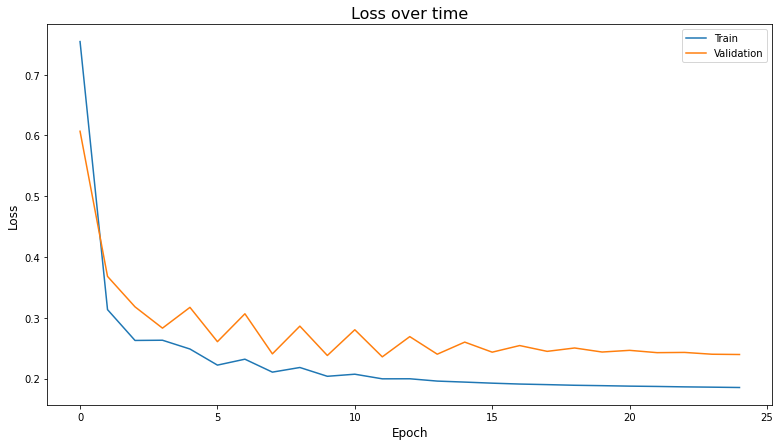

In [ ]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title("Loss over time", fontsize=16)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.show()

It does not seem like the model has completely converged, but it is close to doing so - given the limited time, it is an adequate outcome. With more time it might be a good idea to set up an adaptive learning rate and early stopping, and let the model train for longer for optimal results.

# Evaluation

For evaluation of the model I will primarily rely on qualitative visual analysis as the ideal model would perfectly capture the bimodal patterns that were observed previously. Root Mean Squared Error (RMSE) will be used to evaluate the model from a quantitative perspective.

In [ ]:
# Restore best model state and run it on the test set
torch.cuda.empty_cache()
model.load_state_dict(best_model)
model.eval()
X_test_tensor = torch.FloatTensor(test_dataset.X).unsqueeze(-1).to(device)
with torch.no_grad():
  rnn_pred = model(X_test_tensor)
rnn_pred = rnn_pred.detach().cpu().numpy()

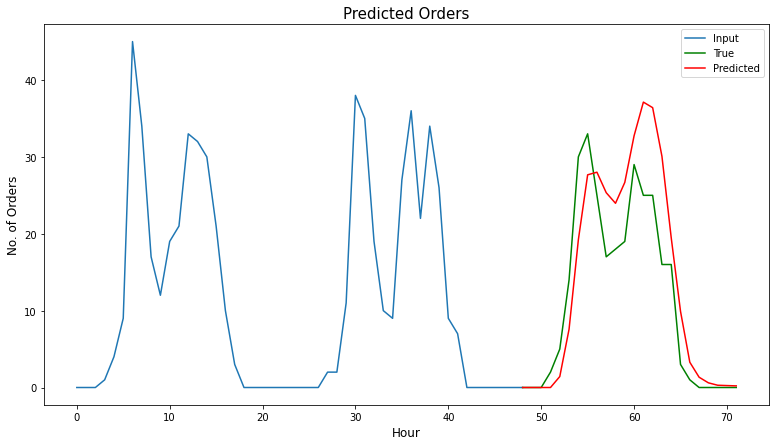

In [ ]:
predicted = test_dataset.unscale(rnn_pred[0, :])
predicted[predicted < 0] = 0

plt.plot(np.arange(history_interval+1), np.r_[test_dataset.unscale(test_dataset.X[0, :]), test_dataset.unscale(test_dataset.y[0, 0])], label="Input")
plt.plot(np.arange(history_interval, history_interval + predict_interval), test_dataset.unscale(test_dataset.y[0, :]), label="True", c="green")
plt.plot(np.arange(history_interval, history_interval + predict_interval), predicted, label="Predicted", c="red")
plt.title("Predicted Orders", fontsize=15)
plt.xlabel("Hour", fontsize=12)
plt.ylabel("No. of Orders", fontsize=12)
plt.legend()
plt.show()


The above graph looks at the first observation in the test set more closely. Clearly, the model has correctly learned about the bimodal structure in the daily data and makes a good guess about when the peaks happen, but it does not do a great job of predicting the correct values for the peaks.

In [ ]:
def plot_predictions(true, pred, time, is_scaled=False, 
                     std=norm_std, mean=norm_mean):

  if not is_scaled: 
    pred = (pred * std) + mean
  pred[pred < 0] = 0
  rmse = np.sqrt((np.sum((true[:, time] - pred[:, time])**2)) / true.shape[0])

  plt.plot(true[:, time], label="True")
  plt.plot(pred[:, time], label="Pred")
  plt.suptitle(f"Predictions {time+1} hour(s) in the future", fontsize=15)
  plt.title('Root mean squared error: {}'.format(round(rmse, 3)))
  plt.legend()
  plt.xlabel("Timestep")
  plt.ylabel("No. of Orders")

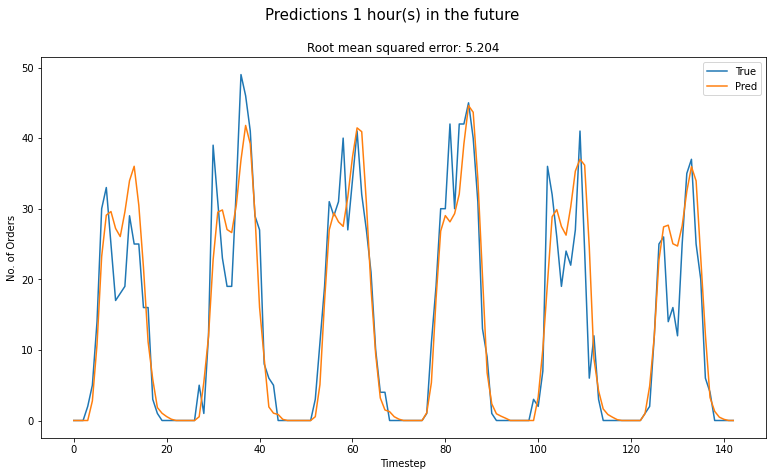

In [ ]:
plot_predictions(y_test_unnorm, rnn_pred, 0)

Here, the model's predictions for the entire test set are shown when considering the model's predictions one hour into the future. Again we see that the model does a good job in predicting the average number of orders per day, but does not exactly capture the daily two peak values.

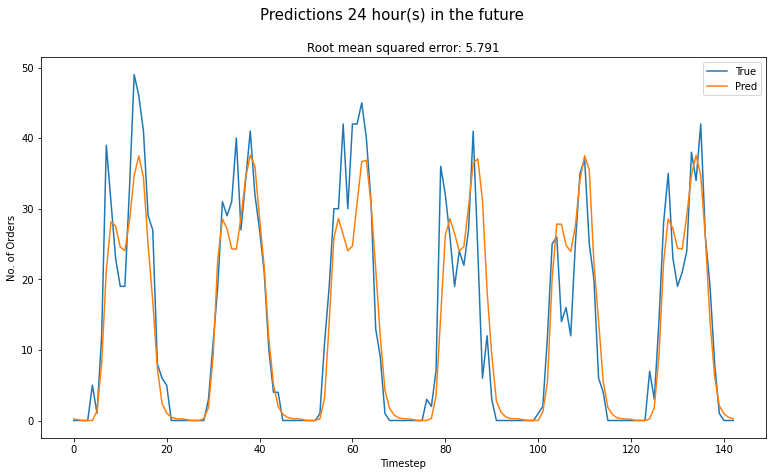

In [ ]:
plot_predictions(y_test_unnorm, rnn_pred, 23)

When evaluating the model for predictions 24 hours into the future, its performance is expectedly worse, but not overly so: these predictions are not much worse than for 1 hour into the future. The same problem of not capturing peaks well remains an issue.

Overall, I would say these results are promising for a first prototype model. The model has learned the patterns in the data and does a decent job understanding if a given day will have more or fewer total orders. As there are usually 20 to 50 orders in a given hour, having an RMSE of 5 to 6 orders is not too bad either as it would likely still allow for informed business decisions to be made, but obviously a model with a smaller error is desireable.

This model would probably not work as well when used on time periods further away from the training data - the total amount and distribution of orders is likely different at various parts of the year, so a model that has only seen how the data behaves in August and September might not generalize well to other time periods. This issue could be largely mitigated by using more data - a year's worth at least to ensure the model understands yearly seasonal patterns. 

# Extending the Model

As mentioned earlier, it is likely that the distributions of orders share similarities across the same weekdays. The current model does not have direct access to what day the target data belongs to, but it may be able to make a guess based on the input data. Still, we can feed the weekday info into the model in hopes of improving it.

To do so, we will take the weekday info for the first day of the 48 hours of data that is fed into the model - this is sufficient for the model to know what days it is given and what day it will predict. The weekday information is one-hot encoded. Then, when the encoder produces its hidden state output, the hidden state along with the one-hot weekday information is sent through a fully connected layer to produce a new hidden state that contains the weekday information. This state is then passed to the decoder as previously.

The below code is largely the same as the code above. Any differences are pointed out by comments.

In [ ]:
predict_interval = 24
history_interval = 48
trim = predict_interval + history_interval

indices = np.stack([np.arange(i, trim+i) for i in range(gb.shape[0] - trim + 1)])
data = np.stack([gb.orders.iloc[indices[i]] for i in range(indices.shape[0])])

# Fetch weekday data for each observation and one-hot encode it
weekday = np.stack([gb.weekday.iloc[indices[i][0]] for i in range(indices.shape[0])])
enc = OneHotEncoder()
weekday = enc.fit_transform(weekday.reshape(-1, 1)).toarray()

X = data[:, :history_interval]
y = data[:, history_interval:]

X_train = X[:1100]
y_train = y[:1100]
weekday_train = weekday[:1100]
X_val = X[1100:1250]
y_val = y[1100:1250]
weekday_val = weekday[1100:1250]
X_test = X[1250:]
y_test = y[1250:]
weekday_test = weekday[1250:]
y_test_unnorm = y_test.copy()

norm_mean = X_train.mean()
norm_std = X_train.std()

def normalize(arr):
  return (arr - norm_mean) / norm_std

vars = [X_train, y_train, X_val, y_val, X_test, y_test]
for var in vars:
  var[:] = normalize(var)

class WoltDataset(Dataset): 
  def __init__(self, X, y, additional):

    self.X = X
    self.y = y 
    # Include matrix of additional information in the dataset
    self.additional = additional

  def __getitem__(self, idx):
    return self.X[idx, :], self.y[idx, :], self.additional[idx, :]

  def __len__(self):
    return self.X.shape[0]

  def unscale(self, X):
    return (X * norm_std) + norm_mean

train_dataset = WoltDataset(X_train, y_train, weekday_train)
val_dataset = WoltDataset(X_val, y_val, weekday_val)
test_dataset = WoltDataset(X_test, y_test, weekday_test)

In [ ]:
BATCH_SIZE = 32
EPOCHS = 50
LR = 1e-4
HIDDEN_SIZE = 256

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
class WoltEncoderDecoder_additional(nn.Module):

  def __init__(self, hidden_size, output_size, additional_size):
    super().__init__()
    self.encoder = WoltEncoder(hidden_size)
    self.decoder = WoltDecoder(hidden_size)
    self.output_size = output_size
    # Additional fully connected layer to add weekday information
    self.fc = nn.Sequential(
        nn.Linear(hidden_size + additional_size, hidden_size),
        nn.LeakyReLU()
    )

  def forward(self, x, additional):

    encoder_out, hidden = self.encoder(x)
    # Add weekday information to time series data to produce new hidden state
    hidden = self.fc(torch.cat((hidden, additional), dim=1))
    N = x.shape[0]
    outputs = torch.empty(N, self.output_size)
    curr = x[:, -1]
    for i in range(self.output_size):
      curr, hidden = self.decoder(curr, hidden)
      outputs[:, i] = curr.view(-1)

    return outputs

In [ ]:
model = WoltEncoderDecoder_additional(HIDDEN_SIZE, predict_interval, weekday.shape[1])
optimizer = optim.AdamW(model.parameters(), lr=LR)
criterion = nn.MSELoss()
model = model.to(device)

In [ ]:
train_losses = []
val_losses = []

best_model = model.state_dict()
best_val_loss = np.inf

for epoch in range(EPOCHS):
  #t = tqdm(train_dataloader, desc=f"Epoch: {epoch}") # Uncomment and comment out the next line to get cool progress bars!
  t = train_dataloader
  cost = 0
  # Training
  for i, (prev, target, additional) in enumerate(t):
    pred = model(prev.unsqueeze(-1).float().to(device), additional.float().to(device))
    loss = criterion(pred, target.float())
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    cost += float(loss.item() * prev.shape[0])

  train_losses.append(cost/len(train_dataset))

  # Validation
  with torch.no_grad():
    val_cost = 0
    for prev, target, additional in val_dataloader:
      pred = model(prev.unsqueeze(-1).float().to(device), additional.float().to(device))
      loss = criterion(pred, target.float())

      val_cost += float(loss.item() * prev.shape[0])
    val_loss = val_cost/len(val_dataset)
    val_losses.append(val_loss)

    # Keep model with best validation loss
    if val_loss < best_val_loss:
      best_model = model.state_dict()
      best_val_loss = val_loss

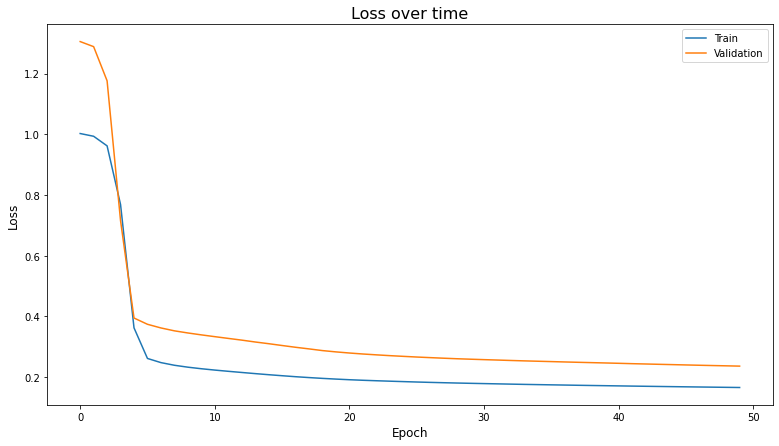

In [ ]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title("Loss over time", fontsize=16)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.show()

It seems that just like the last model, this one hasn't fully converged and could likewise benefit from an adaptive learning rate and more training.

In [ ]:
# Restore best model state and run it on the test set
torch.cuda.empty_cache()
model.load_state_dict(best_model)
model.eval()
X_test_tensor = torch.FloatTensor(test_dataset.X).unsqueeze(-1).to(device)
with torch.no_grad():
  rnn_pred = model(X_test_tensor, torch.FloatTensor(weekday_test).to(device))
rnn_pred = rnn_pred.detach().cpu().numpy()

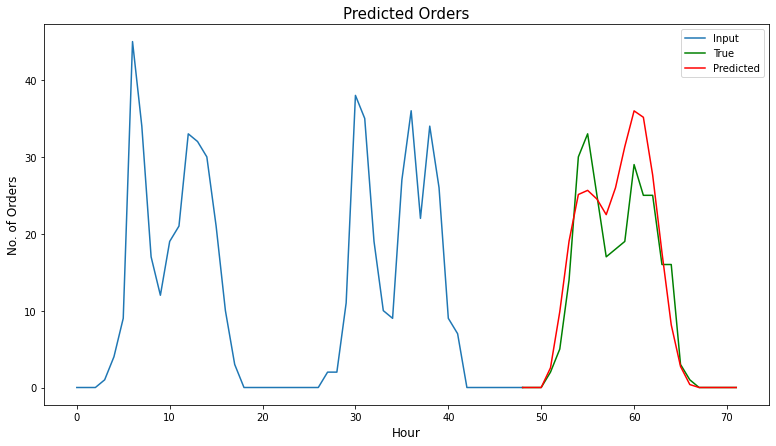

In [ ]:
predicted = test_dataset.unscale(rnn_pred[0, :])
predicted[predicted < 0] = 0

plt.plot(np.arange(history_interval+1), np.r_[test_dataset.unscale(test_dataset.X[0, :]), test_dataset.unscale(test_dataset.y[0, 0])], label="Input")
plt.plot(np.arange(history_interval, history_interval + predict_interval), test_dataset.unscale(test_dataset.y[0, :]), label="True", c="green")
plt.plot(np.arange(history_interval, history_interval + predict_interval), predicted, label="Predicted", c="red")
plt.title("Predicted Orders", fontsize=15)
plt.xlabel("Hour", fontsize=12)
plt.ylabel("No. of Orders", fontsize=12)
plt.legend()
plt.show()


For this instance, the results do not differ much from the simpler model - the model still doesn't capture the peaks very well.

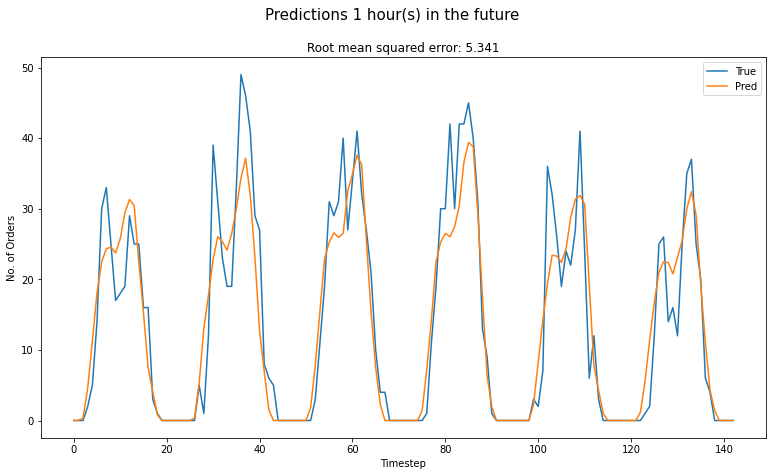

In [ ]:
plot_predictions(y_test_unnorm, rnn_pred, 0)

On various runs I was able to obtain results that both beat and fail to beat the simpler model. On average, however, it seems that this model is a slight improvement, but randomization has a large part in the results.

The issue of not capturing the daily peaks correctly is more complicated to fix than just adding little additional information, clearly.

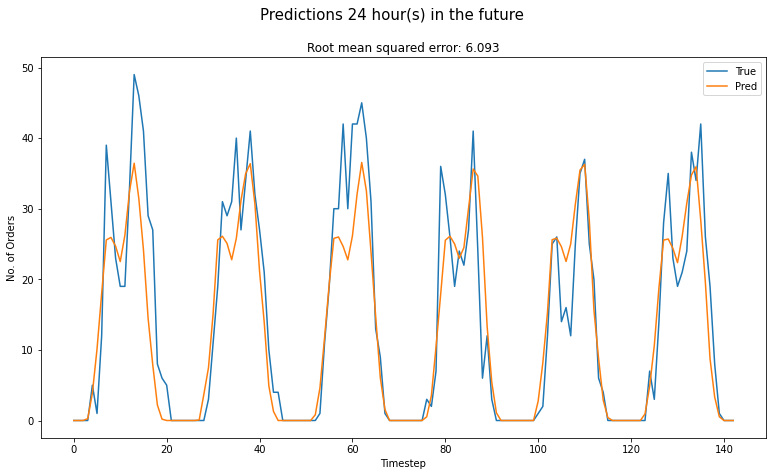

In [ ]:
plot_predictions(y_test_unnorm, rnn_pred, 23)

A bit surprisingly, this model tends to perform significantly worse than the simpler one on predictions 24 hours into the future. It might be worth reconsidering the way the additional weekdays information is incorporated into the model.

Overall, it is clear that this model can be improved upon. It would greatly benefit from having lots more training data. Feeding more additional non-time series data into the model can only do good as well. However, even just the additional weekday information made training the model significantly slower - there is definitely a tradeoff between predictive performance and runtime performance here.

It is also important to note that this model has been trained to predict a complete day from 00:00 to 23:59. It would likely not work as well if it had to predict, say, Wednesday 12:00 to Thursday 11:59. To allow for this, we could feed the clock hour information of one or many datapoints to the model as well.

# My Background

### Why Wolt?

I am looking for an opportunity where I can put my data science skills to practice to deliver impactful business value and benefit stakeholders. An ideal role would allow me to directly communicate with stakeholders to then produce the most suitable solution together with my peers. 

Data science is central to Wolt's operations, so I am very thrilled about the idea of working as part of Wolt's data science team. What really excites me about working at Wolt is the thought of what a huge logistical challenge Wolt's operations must be, and how much data science could be used to solve these challenges. Wolt's data science team is world class - I feel I would have so much to learn from them while hopefully also benefitting the team back through my own unique knowledge and experiences.

### My Education

I am currently finishing up my Data Science Honours BSc degree at the University of Toronto, which is often ranked in the top 10 universities in the world in the field of computer science. As this is a four-year degree program, it is comparable to a BSc+MSc obtained in Europe. I feel confident in my skills in most of the common data science paradigms, but my strongest interests are in deep learning and its uses in regression, classification and computer vision. Currently, I am focusing a large part of my effort to improving my natural language processing skills and knowledge. At Wolt, I do not have a particular problem I would want to solve or a particular technique I would want to use. What is most important to me is that I get to take on tasks that produce genuinely useful value and impact for Wolt, its partners, and its customers, using whatever tools necessary to get the job done.

### My Professional Experience

Nearly all of the things I have studied in school I have already put to use in industry through the numerous internships I have had. I have solved problems with great success in domains completely different from each other such as insurance, renewable energy, telecommunications, and virology. For solving these problems, I have relied on vastly different techniques, ranging from deep learning to plain linear regression to simple visualization analysis. What was common between all of these experiences was the process of communicating with stakeholders to understand what is most important, and translating the issues brought up into data science problems. What I would bring to Wolt is a great ability to understand business needs and how data science can be best used to satisfy them. I have built up my skills and knowledge in a way that allows me to always find suitable tools to solve whatever problem may arise.

### My Extracurriculars

When data science isn't on my mind, I really enjoy playing chess, going swimming and working out, playing and watching football, and playing video games. In Toronto, I am also an active member in the local Estonian community where I frequently volunteer by helping host events through any way possible: bartending, lifting stuff backstage or hosting livestreams.

### ----------------------------------------------------------

Thanks again for checking out my assignment submission! I hope to hear back from you soon!

#### - Karl